# Support Vector Machines - Demo

Support vector machines (SVMs) are a very powerful and flexible class of supervised algorithms (mostly used for classification).
In this lab, we will develop the intuition behind support vector machines and their use in classification problems.

In [48]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# use seaborn plotting defaults
import seaborn as sns; sns.set()

## Motivating Support Vector Machines

At this point, we consider the simple case of a classification task in which the two classes of points are well separated.

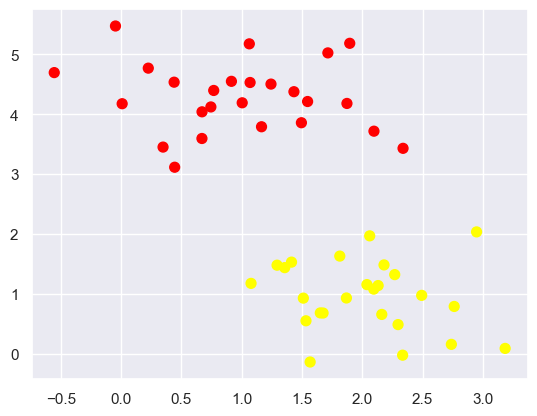

In [49]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

As we saw in class, we want to find an hyperplane that tries to separate these two sets of data, and thereby create a model for classification. In this case, with just two variables, we could find that line by hand.

However, there are infinite solutions to this problem. For example:


(-1.0, 3.5)

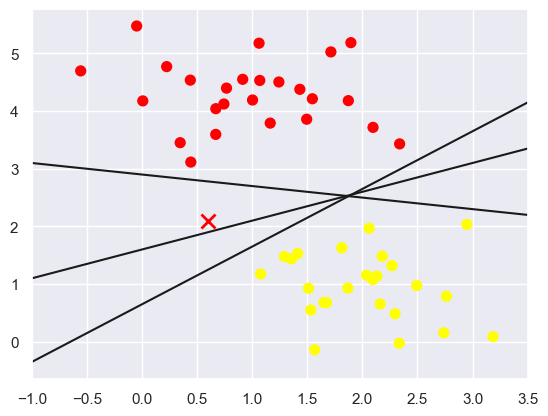

In [50]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5)

Depending on which you choose, a new data point (e.g., the one marked by the "x" in this plot) will be assigned a different label!


As we saw in class, we need to find the better line (hyperplane) according to some metric.

## Support Vector Machines: Maximizing the *Margin*

We look forward the *margin* to each closest point around.

(-1.0, 3.5)

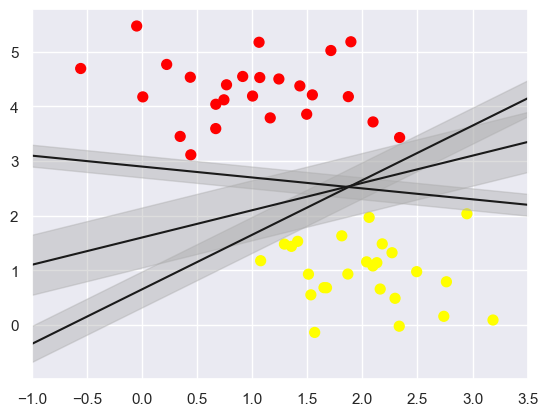

In [51]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5)

In SVM, the line that maximizes this margin is the one we will choose as the optimal model, i.e. the *maximum margin* estimator. Clearly, one of the lines is better than the others in this case.

### Fitting a support vector machine

Let's see the result of an actual fit to this data: we will use Scikit-Learn's support vector classifier to train an SVM model on this data.

For the time being, we will use a linear kernel and set the *C* parameter to a very large number (we'll discuss the meaning of these in more depth momentarily).

In [52]:
from sklearn.svm import SVC
model = SVC(kernel='linear', C=1e10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

To better visualize what's happening here, let's create a quick convenience function that will plot SVM decision boundaries for us:

In [53]:
def plot_SVM_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVM"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)

    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

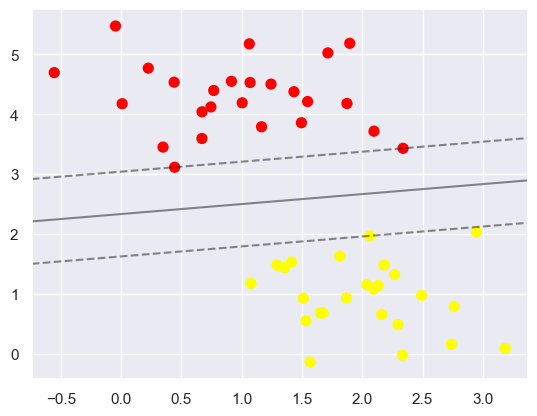

In [54]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_SVM_decision_function(model)

The result is the dividing hyperplane (line in our 2 dimensions) that maximizes the margin between the two sets of points.
Notice that a few of the training points just touch the margin: they are *support vectors*, and give the algorithm its name.
Let's see who this points are:

In [55]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

In [65]:
model.intercept_

array([2.14922325])

A key to this classifier's success is that for the fit, only the position of the support vectors matter; any points further from the margin which are on the correct side do not modify the fit!
Technically, this is because these points do not contribute to the loss function used to fit the model (C is very large), so their position and number do not matter so long as they do not cross the margin.

We can see this, for example, if we plot the model learned from the first 60 points and first 120 points of this dataset:

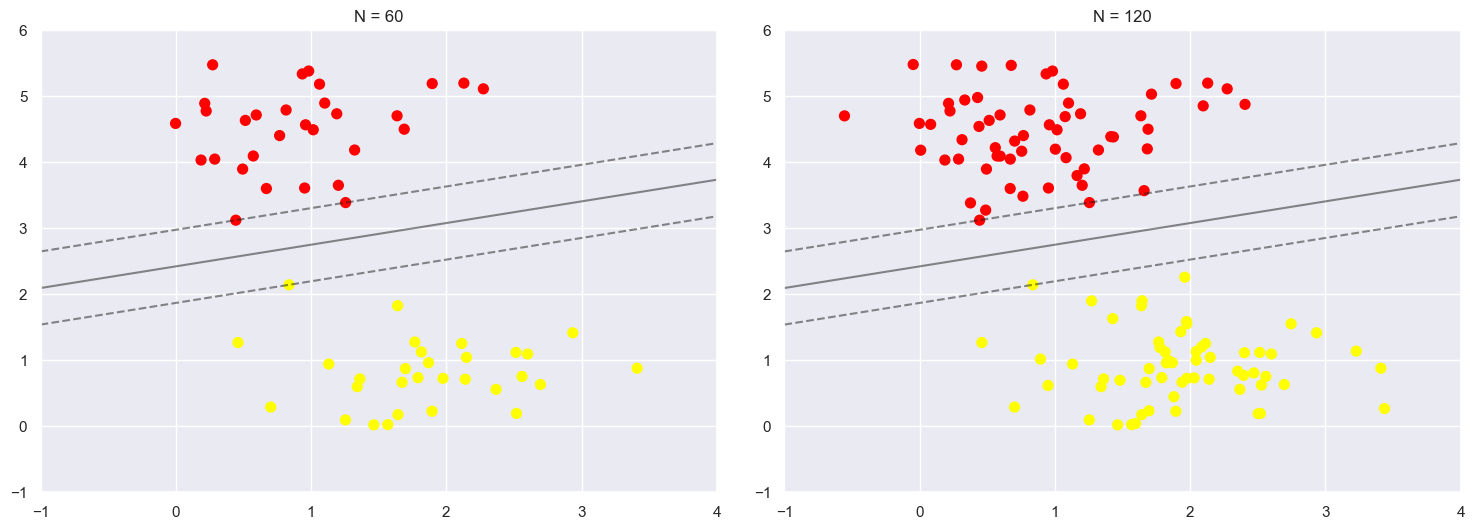

In [56]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1e10)
    model.fit(X, y)

    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_SVM_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title(f'N = {N}')

In the left figure, we see the model and the support vectors for 60 training points.
In the right panel, we have doubled the number of training points, but the model has not changed: the three support vectors from the left panel are still the support vectors from the right panel.
This insensitivity to the exact behavior of distant points is one of the strengths of the SVM model.

### Beyond linear boundaries: Kernel SVM - Gaussian kernel

As you already must know, the SVM becomes extremely powerful is when it is combined with *kernels*.

Kernels consist basically in projecting our data into higher-dimensional space defined by polynomials or Gaussian basis functions, and thereby, we are able to fit for nonlinear relationships with a linear classifier.

Remember that through *Kernels*, we are able to use very high-dimensional data without the burden of calculating it (al least the high-dimensional vector themselves).

To further motivate the need for kernels, let's look at some data that is not linearly separable:

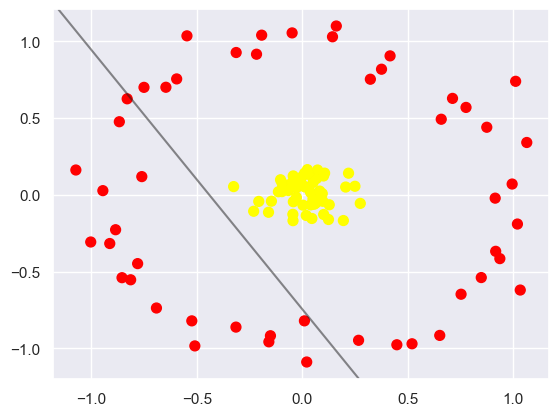

In [57]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_SVM_decision_function(clf, plot_support=False)

Clearly, no hyperplane (line) will *ever* be able to separate this data.
However, think about how we might project the data into a higher dimension such that a linear separator *would* be sufficient.

For example, one simple projection we could use would be to compute a *radial basis function* centered on the middle point, i.e. (0,0):

In [58]:
r = np.exp(-((X - np.zeros((1,2))) ** 2).sum(axis = 1))

We can visualize this extra data dimension using a three-dimensional plot.

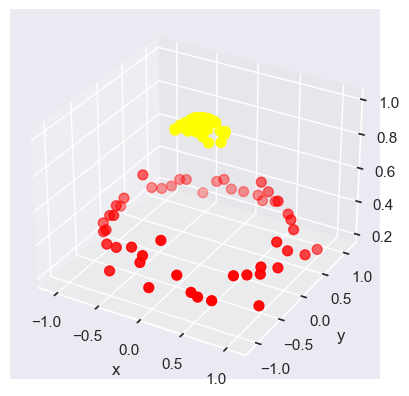

In [59]:
def plot_3D(X=X, r=r, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

plot_3D(X,r,y)

As it can be observed, with this additional dimension, the data becomes trivially linearly separable, by drawing a separating plane at *r*=0.7 (for example, the maximum margin estimator may be slighly higher or lower).

In [60]:
clf = SVC(kernel='rbf', C=1e6) # By default it was kernel='linear'
clf.fit(X, y)

SVC(C=1000000.0)

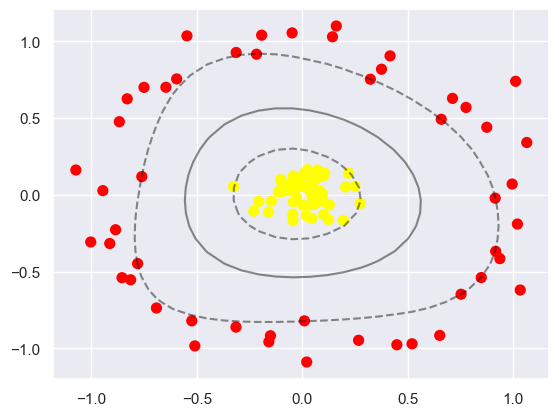

In [61]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_SVM_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

Using this kernelized support vector machine, we learned a suitable nonlinear decision boundary.

And finally, the support vector in this case are given by:

In [62]:
clf.support_vectors_

array([[ 0.75366067, -0.64703041],
       [ 0.01039061, -0.82059172],
       [-0.780973  , -0.44755801],
       [ 0.65956275,  0.49312102],
       [ 0.32328611,  0.75379541],
       [-0.21683832,  0.91675095],
       [-0.76117686,  0.11927393],
       [ 0.91552876, -0.02103097],
       [ 0.27543323, -0.05524152],
       [-0.3255058 ,  0.05429713]])

### Tuning the SVM: Softening Margins

The previous dataset could be totally separated, but what happens if your data has some amount of overlap?
Let's go through an example:

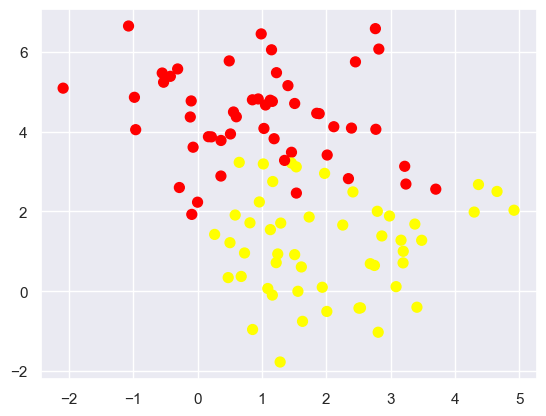

In [63]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

For this cases, the SVM implementation has a "soften" margin, by allowing some of the points to be inside the margin. This is controlled by the regularization parameter $C$, which controls the *penalty* for allowing points to lie inside the margin.

Therefore, for large values of $C$, fewer points will lie inside, and, for small values of $C$, the margin is softer, allowing margins with more points inside them.

Let's check this with an example.

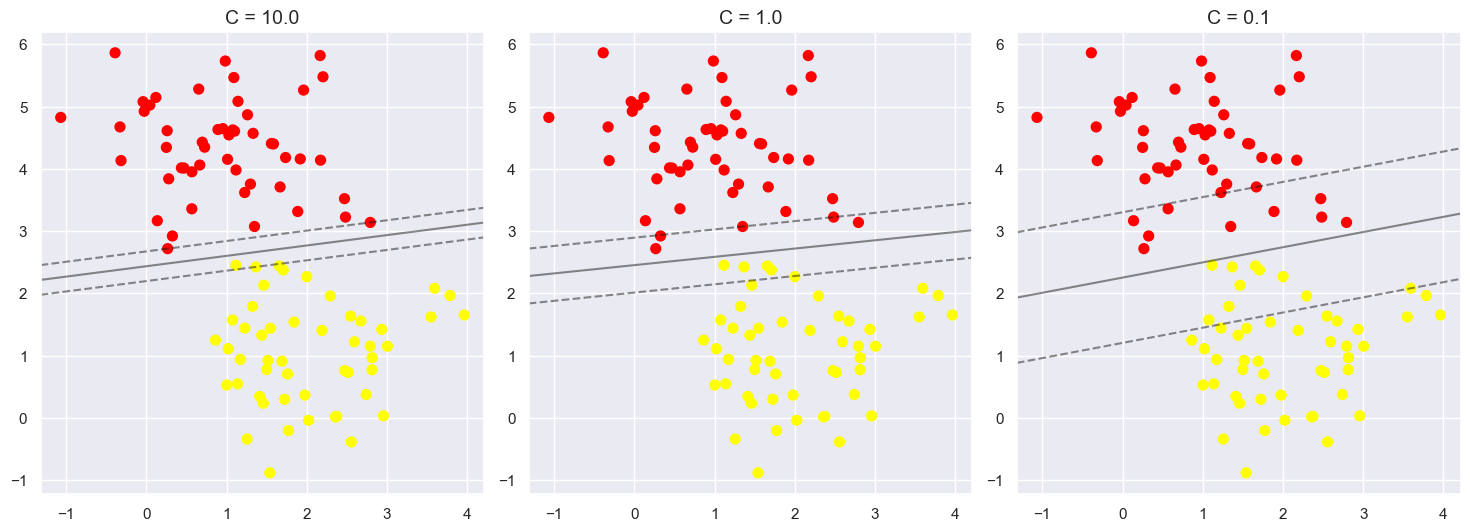

In [64]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 3, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 1, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_SVM_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

The optimal value of the $C$ parameter will depend on your dataset, and should be tuned using normal (or cross-) validation.